# Predicting Housing Prices Using Regression Trees and Ensemble Learning

- Andrea Lima Blanca
- Dicka Jamesina Lezama Alvarado
- Diego Gasparis Escobedo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import StandardScaler

In [ ]:
dataset_path = '/content/drive/My Drive/Housing.csv'
data = pd.read_csv(dataset_path)

In [ ]:
data_head = data.head()
data_description = data.describe(include='all')

# Data exploration and pre-processing
Perform descriptive statistics and visualization of the data to understand the relationships between features (e.g., scatter plots, heatmaps).
Handle missing data, outliers, and categorical variables (e.g., one-hot encoding or label encoding).

In [ ]:
def preprocess_data(data):
    """
    Preprocesses the data by converting categorical variables to numerical values.
    """
    df = data.copy()
    df.replace({'yes': 1, 'no': 0}, inplace=True)
    df.infer_objects(copy=False)  # Retain downcasting behavior for 'yes' and 'no'
    df.replace({'unfurnished': 0, 'furnished': 1, 'semi-furnished': 2}, inplace=True)
    df.infer_objects(copy=False)  # Retain downcasting behavior for furnishing status
    return df

df = preprocess_data(data)

<ipython-input-8-1228c846492e>:6: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'yes': 1, 'no': 0}, inplace=True)
<ipython-input-8-1228c846492e>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace({'unfurnished': 0, 'furnished': 1, 'semi-furnished': 2}, inplace=True)


In [ ]:
df.describe()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.858716,0.177982,0.350459,0.045872,0.315596,0.693578,0.234862,1.089908
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.348635,0.382849,0.477552,0.209399,0.465180,0.861586,0.424302,0.858130
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,2.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.000000


In [ ]:
def calculate_price_per_sqft(df):
    """
    Calculates and displays statistics for price per square foot.
    """
    df['price_per_sqft'] = df['price'] / df['area']
    print("\nPrice per square foot statistics:")
    print(df['price_per_sqft'].describe())
    return df

calculate_price_per_sqft(df)


Price per square foot statistics:
count     545.000000
mean      993.326978
std       346.537025
min       270.395550
25%       745.370370
50%       952.380952
75%      1184.615385
max      2640.000000
Name: price_per_sqft, dtype: float64


,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus,price_per_sqft
0,13300000,7420,4,2,3,1,0,0,0,1,2,1,1,1792.452830
1,12250000,8960,4,4,4,1,0,0,0,1,3,0,1,1367.187500
2,12250000,9960,3,2,2,1,0,1,0,0,2,1,2,1229.919679
3,12215000,7500,4,2,2,1,0,1,0,1,3,1,1,1628.666667
4,11410000,7420,4,1,2,1,1,1,0,1,2,0,1,1537.735849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,1,1,0,1,0,0,2,0,0,606.666667
541,1767150,2400,3,1,1,0,0,0,0,0,0,0,2,736.312500
542,1750000,3620,2,1,1,1,0,0,0,0,0,0,0,483.425414
543,1750000,2910,3,1,1,0,0,0,0,0,0,0,1,601.374570


In [ ]:
def detect_outliers(df):
    """
    Detects outliers in numerical columns using the Z-score method.
    """
    numeric_columns = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
    outliers = {}
    for col in numeric_columns:
        z_scores = np.abs(stats.zscore(df[col]))
        outliers[col] = len(df[z_scores > 3])

    print("\nNumber of outliers (|Z-score| > 3):")
    for col, count in outliers.items():
        print(f"{col}: {count}")

detect_outliers(df)


Number of outliers (|Z-score| > 3):
price: 6
area: 7
bedrooms: 2
bathrooms: 11
stories: 0
parking: 0


In [ ]:
def visualize_data(df):
    """
    Generates visualizations including a correlation heatmap, price distribution,
    price vs area scatter plot, for categorical variables.
    """
    plt.style.use('ggplot')

    # Correlation Heatmap
    plt.figure(figsize=(10, 8))
    correlation_matrix = df.corr()
    mask = np.triu(np.ones_like(correlation_matrix), k=1)
    sns.heatmap(correlation_matrix,
                mask=mask,
                annot=True,
                cmap='coolwarm',
                fmt=".2f",
                square=True,
                vmin=-1,
                vmax=1)
    plt.title("Correlation Heatmap")
    plt.tight_layout()
    plt.show()

    # Distribution of Price
    plt.figure(figsize=(10, 8))
    sns.histplot(df['price'], kde=True)
    plt.title('Distribution of House Prices')
    plt.xlabel('Price')
    plt.ylabel('Count')
    plt.show()

    # Price vs Area with additional features
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(df['area'],
                         df['price'],
                         c=df['bedrooms'],
                         s=df['parking']*100,
                         alpha=0.6)
    plt.colorbar(scatter, label='Number of Bedrooms')
    plt.title('Price vs Area (bubble size represents parking spaces)')
    plt.xlabel('Area')
    plt.ylabel('Price')
    plt.show()


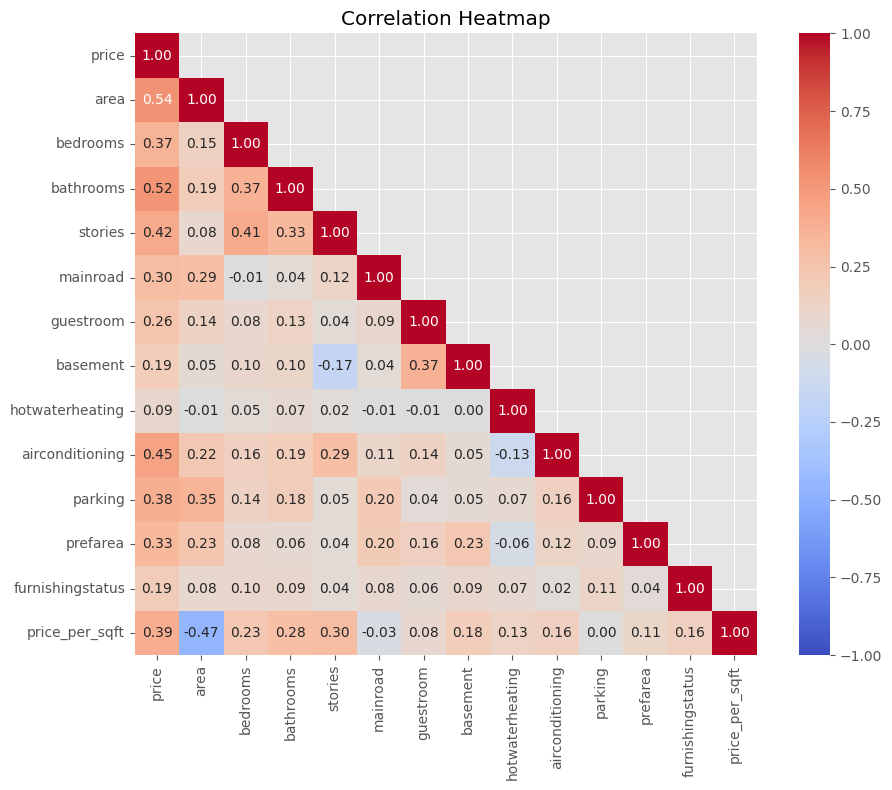

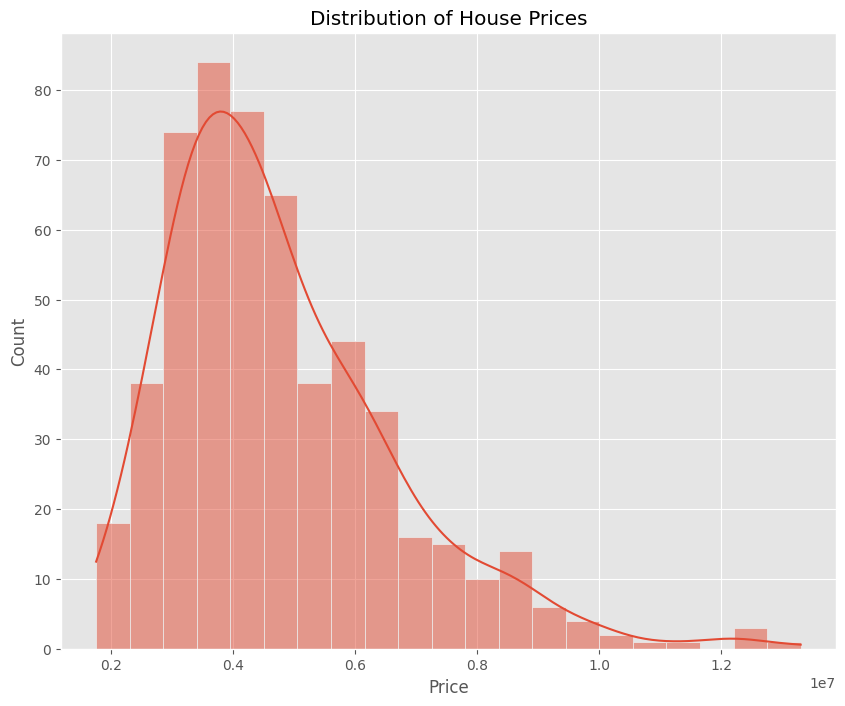

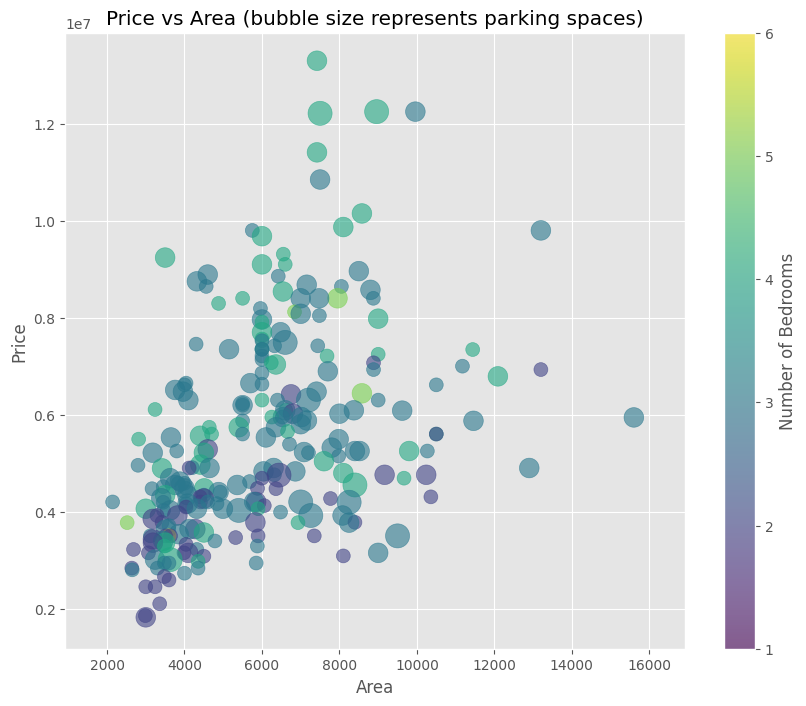

In [ ]:
visualize_data(df)

Split the data into training and testing sets

In [ ]:
def split_data(df, target='price', test_size=0.2, random_state=42):
    """
    Splits the data into training and testing sets.
    """
    X = df.drop(columns=[target])
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = split_data(df)

In [ ]:
print("Shape of original dataset :", data.shape)
print("Shape of X_train", X_train.shape)
print("Shape of y_train", y_train.shape)
print("Shape of X_test", X_test.shape)
print("Shape of y_test", y_test.shape)

Shape of original dataset : (545, 13)
Shape of X_train (436, 13)
Shape of y_train (436,)
Shape of X_test (109, 13)
Shape of y_test (109,)


# Initial Model with Regression Tree:

Train a Decision Tree Regressor as your baseline regression tree model.


In [ ]:
def remove_outliers(df):
    """
    Remove outliers from numerical columns based on Z-score > 3 in a copy of the DataFrame.
    """
    df_no_outliers = df.copy()  # Create a copy to keep the original data unchanged
    numeric_columns = ['price', 'area', 'bedrooms', 'bathrooms', 'stories', 'parking']
    for col in numeric_columns:
        z_scores = np.abs(stats.zscore(df_no_outliers[col]))
        df_no_outliers = df_no_outliers[z_scores <= 3]  # Filter rows with Z-score <= 3
    return df_no_outliers

In [ ]:
def tune_decision_tree(X_train, y_train):
    """
    Use GridSearchCV to find the best parameters for a Decision Tree Regressor.
    """
    tree_regressor = DecisionTreeRegressor(random_state=42)
    param_grid = {
        'max_depth': [3, 4, 5, 6, 7, 8, 10, 12, 15],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4, 6]
    }
    grid_search = GridSearchCV(estimator=tree_regressor, param_grid=param_grid,
                               scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

Use performance metrics: Mean Absolute Error (MAE) and Mean Squared Error (MSE) to evaluate its performance.

In [ ]:
def train_and_evaluate(X_train, X_test, y_train, y_test, params=None):
    """
    Train and evaluate the Decision Tree Regressor model with or without hyperparameter tuning.
    """
    if params:
        model = DecisionTreeRegressor(**params, random_state=42)
    else:
        model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae

In [ ]:
# Split data into training and test sets
df_no_outliers = remove_outliers(df)

X_train_noOutliers, X_test_noOutliers, y_train_noOutliers, y_test_noOutliers = split_data(df_no_outliers)

print("Shape of dataset without outliers:", df_no_outliers.shape)
print("Shape of X_train without outliers:", X_train_noOutliers.shape)
print("Shape of y_train without outliers:", y_train_noOutliers.shape)
print("Shape of X_test without outliers:", X_test_noOutliers.shape)
print("Shape of y_test without outliers:", y_test_noOutliers.shape)

Shape of dataset without outliers: (522, 14)
Shape of X_train without outliers: (417, 13)
Shape of y_train without outliers: (417,)
Shape of X_test without outliers: (105, 13)
Shape of y_test without outliers: (105,)


Results:
1. Original Data, No Tuning - MSE: 404732470183.48627 , MAE: 377775.2293577982
2. No Outliers, No Tuning - MSE: 290376289000.0 , MAE: 367600.0
3. Original Data, With Tuning - MSE: 528580307479.9313 , MAE: 422963.22629969416
4. No Outliers, With Tuning - MSE: 311398487604.8148 , MAE: 382280.4444444445


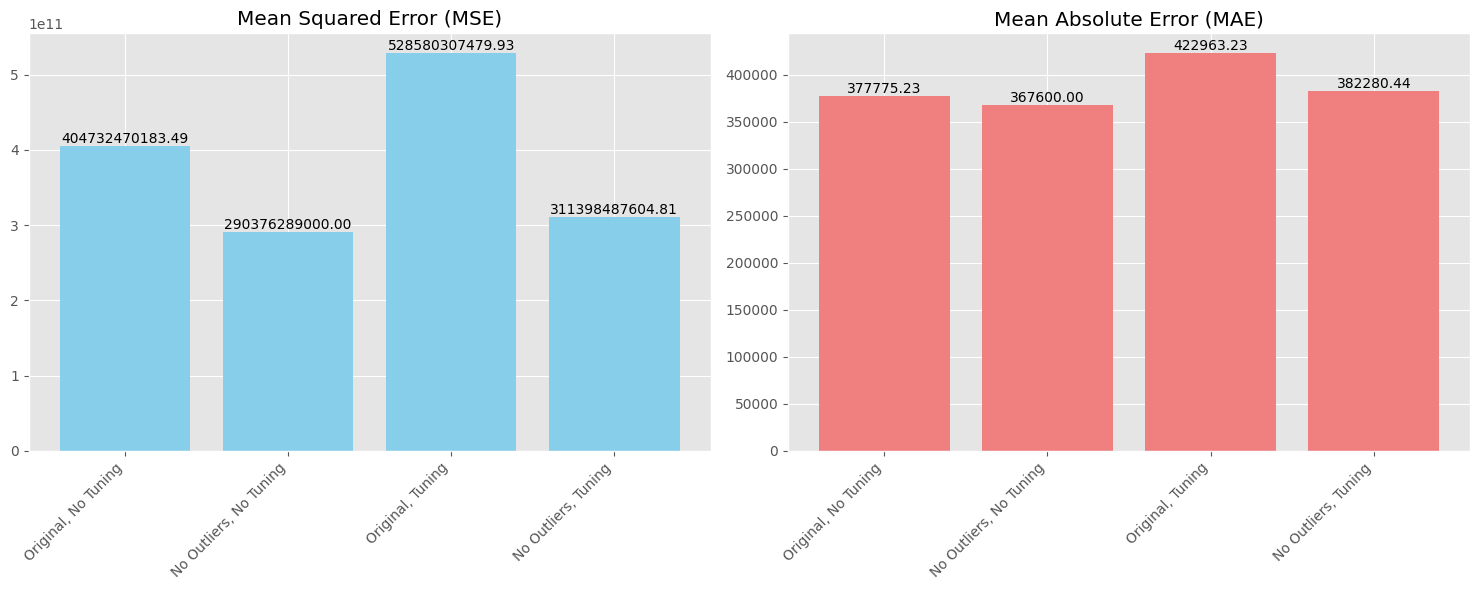

In [ ]:
# Configuration 1: Without tuning, with original data
mse_original, mae_original = train_and_evaluate(X_train, X_test, y_train, y_test)

# Configuration 2: Without tuning, without outliers
mse_no_outliers, mae_no_outliers = train_and_evaluate(X_train_noOutliers, X_test_noOutliers, y_train_noOutliers, y_test_noOutliers)

# Configuration 3: With tuning, original data
best_params_original = tune_decision_tree(X_train, y_train)
mse_tuned_original, mae_tuned_original = train_and_evaluate(X_train, X_test, y_train, y_test, params=best_params_original)

# Configuration 4: With tuning, without outliers
best_params_no_outliers = tune_decision_tree(X_train_noOutliers, y_train_noOutliers)
mse_tuned_no_outliers, mae_tuned_no_outliers = train_and_evaluate(X_train_noOutliers, X_test_noOutliers, y_train_noOutliers, y_test_noOutliers, params=best_params_no_outliers)

# 4. Display results
print("Results:")
print("1. Original Data, No Tuning - MSE:", mse_original, ", MAE:", mae_original)
print("2. No Outliers, No Tuning - MSE:", mse_no_outliers, ", MAE:", mae_no_outliers)
print("3. Original Data, With Tuning - MSE:", mse_tuned_original, ", MAE:", mae_tuned_original)
print("4. No Outliers, With Tuning - MSE:", mse_tuned_no_outliers, ", MAE:", mae_tuned_no_outliers)

# 5. Visualize results
labels = ["Original, No Tuning", "No Outliers, No Tuning", "Original, Tuning", "No Outliers, Tuning"]
mse_values = [mse_original, mse_no_outliers, mse_tuned_original, mse_tuned_no_outliers]
mae_values = [mae_original, mae_no_outliers, mae_tuned_original, mae_tuned_no_outliers]

# Create two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Create positions for the bars
x = np.arange(len(labels))

# MSE Plot
bars_mse = ax1.bar(x, mse_values, color='skyblue')
ax1.set_title('Mean Squared Error (MSE)')
ax1.set_xticks(x)  # Set label positions
ax1.set_xticklabels(labels, rotation=45, ha='right')
for bar in bars_mse:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# MAE Plot
bars_mae = ax2.bar(x, mae_values, color='lightcoral')
ax2.set_title('Mean Absolute Error (MAE)')
ax2.set_xticks(x)  # Set label positions
ax2.set_xticklabels(labels, rotation=45, ha='right')
for bar in bars_mae:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

# Ensemble Learning Techniques:

## Random Forest Regressor

A collection of decision trees working together for more robust predictions.

In [ ]:
def train_random_forest(X_train, X_test, y_train, y_test, n_estimators=100, max_depth=None, random_state=42):
    """
    Train a Random Forest Regressor and evaluate it on the test set.
    """
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae


## Gradient Boosting Regressor
Builds trees sequentially to correct errors made by previous trees.

In [ ]:
def train_gradient_boosting(X_train, X_test, y_train, y_test, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
    """
    Train a Gradient Boosting Regressor and evaluate it on the test set.
    """
    model = GradientBoostingRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae


#XGBoost
An efficient implementation of gradient boosting, particularly useful for large datasets.

In [ ]:
def train_xgboost(X_train, X_test, y_train, y_test, n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42):
    """
    Train an XGBoost Regressor and evaluate it on the test set.
    """
    model = xgb.XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth, random_state=random_state)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse, mae

Results for each model

In [ ]:
# Random Forest
mse_rf, mae_rf = train_random_forest(X_train, X_test, y_train, y_test)
mse_rf_noOutliers, mae_rf_noOutliers = train_random_forest(X_train_noOutliers, X_test_noOutliers, y_train_noOutliers, y_test_noOutliers)
print("Random Forest Regressor - MSE:", mse_rf, ", MAE:", mae_rf)
print("Random Forest Regressor (dataset without outliers) - MSE:", mse_rf_noOutliers, ", MAE:", mae_rf_noOutliers)

# Gradient Boosting
mse_gb, mae_gb = train_gradient_boosting(X_train, X_test, y_train, y_test)
mse_gb_noOutliers, mae_gb_noOutliers= train_gradient_boosting(X_train_noOutliers, X_test_noOutliers, y_train_noOutliers, y_test_noOutliers)
print("Gradient Boosting Regressor - MSE:", mse_gb, ", MAE:", mae_gb)
print("Gradient Boosting Regressor (dataset without outliers) - MSE:", mse_gb_noOutliers, ", MAE:", mae_gb_noOutliers)

# XGBoost
mse_xgb, mae_xgb = train_xgboost(X_train, X_test, y_train, y_test)
mse_xgb_noOutliers, mae_xgb_noOutliers= train_xgboost(X_train_noOutliers, X_test_noOutliers, y_train_noOutliers, y_test_noOutliers)
print("XGBoost Regressor - MSE:", mse_xgb, ", MAE:", mae_xgb)
print("XGBoost Boosting Regressor (dataset without outliers) - MSE:", mse_xgb_noOutliers, ", MAE:", mae_xgb_noOutliers)


Random Forest Regressor - MSE: 332257948418.56537 , MAE: 283225.5165137614
Random Forest Regressor (dataset without outliers) - MSE: 127649686640.392 , MAE: 232461.6933333333
Gradient Boosting Regressor - MSE: 186923200686.80066 , MAE: 259604.3220374091
Gradient Boosting Regressor (dataset without outliers) - MSE: 84739158100.70702 , MAE: 215114.15786055085
XGBoost Regressor - MSE: 214687509444.96173 , MAE: 288391.0722477064
XGBoost Boosting Regressor (dataset without outliers) - MSE: 118883550580.21756 , MAE: 245495.86666666667


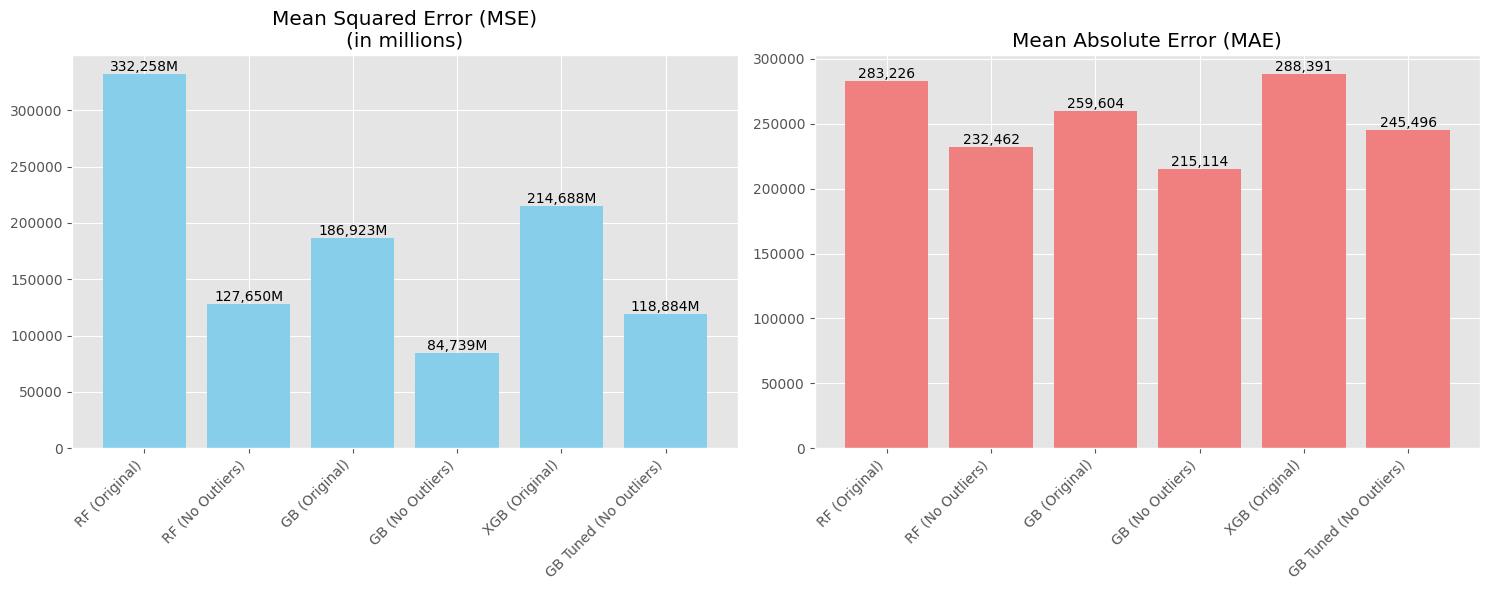

In [ ]:
# Organize the data
models = [
    'RF (Original)',
    'RF (No Outliers)',
    'GB (Original)',
    'GB (No Outliers)',
    'XGB (Original)',
    'GB Tuned (No Outliers)'
]

mse_values = [
    mse_rf,
    mse_rf_noOutliers,
    mse_gb,
    mse_gb_noOutliers,
    mse_xgb,
    mse_xgb_noOutliers
]

mae_values = [
    mae_rf,
    mae_rf_noOutliers,
    mae_gb,
    mae_gb_noOutliers,
    mae_xgb,
    mae_xgb_noOutliers
]

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Positions for the bars
x = np.arange(len(models))

# Plot MSE (converting to millions for better readability)
mse_in_millions = [mse/1_000_000 for mse in mse_values]
bars_mse = ax1.bar(x, mse_in_millions, color='skyblue')
ax1.set_title('Mean Squared Error (MSE)\n(in millions)')
ax1.set_xticks(x)
ax1.set_xticklabels(models, rotation=45, ha='right')
for bar in bars_mse:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}M',
             ha='center', va='bottom')

# Plot MAE
bars_mae = ax2.bar(x, mae_values, color='lightcoral')
ax2.set_title('Mean Absolute Error (MAE)')
ax2.set_xticks(x)
ax2.set_xticklabels(models, rotation=45, ha='right')
for bar in bars_mae:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:,.0f}',
             ha='center', va='bottom')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Model Optimization using Grid Search:

Use GridSearchCV or RandomizedSearchCV to tune hyperparameters such as:

- Number of trees (for Random Forest and XGBoost)
- Depth of trees
- Learning rate (for Gradient Boosting and XGBoost)


In [ ]:
def tune_random_forest(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],  # Number of trees
        'max_depth': [10, 20, 30, None],  # Depth of trees
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf,
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)

    print("Random Forest Best Parameters:")
    print(grid_search.best_params_)
    print("Best Score (MSE):", -grid_search.best_score_)

    return grid_search.best_estimator_

In [ ]:
def tune_gradient_boosting(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],   # Number of trees
        'learning_rate': [0.01, 0.1, 0.3], # Learning rate
        'max_depth': [3, 4, 5],            # Depth of trees
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }

    gb = GradientBoostingRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=gb,
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)

    print("\nGradient Boosting Best Parameters:")
    print(grid_search.best_params_)
    print("Best Score (MSE):", -grid_search.best_score_)

    return grid_search.best_estimator_

In [ ]:
def tune_xgboost(X_train, y_train):
    param_grid = {
        'n_estimators': [100, 200, 300],   # Number of trees
        'learning_rate': [0.01, 0.1, 0.3], # Learning rate
        'max_depth': [3, 4, 5],            # Depth of trees
        'min_child_weight': [1, 3, 5],
        'subsample': [0.8, 0.9, 1.0]
    }

    xgb_model = xgb.XGBRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=xgb_model,
                               param_grid=param_grid,
                               cv=5,
                               n_jobs=-1,
                               scoring='neg_mean_squared_error')

    grid_search.fit(X_train, y_train)

    print("\nXGBoost Best Parameters:")
    print(grid_search.best_params_)
    print("Best Score (MSE):", -grid_search.best_score_)

    return grid_search.best_estimator_


## Find the best hyperparameters to maximize performance.

In [ ]:
# Function to evaluate the model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)

    return mse, mae

In [ ]:
# Tuning and evaluating models with the original dataset
print("Tuning models with original data...")
best_rf = tune_random_forest(X_train, y_train)
best_gb = tune_gradient_boosting(X_train, y_train)
best_xgb = tune_xgboost(X_train, y_train)

# Evaluate tuned models with the original dataset
print("\nEvaluating tuned models with original data:")
best_mse_rf, best_mae_rf = evaluate_model(best_rf, X_train, X_test, y_train, y_test)
best_mse_gb, best_mae_gb = evaluate_model(best_gb, X_train, X_test, y_train, y_test)
best_mse_xgb, best_mae_xgb = evaluate_model(best_xgb, X_train, X_test, y_train, y_test)

print(f"\nRandom Forest - MSE: {best_mse_rf}, MAE: {best_mae_rf}")
print(f"Gradient Boosting - MSE: {best_mse_gb}, MAE: {best_mae_gb}")
print(f"XGBoost - MSE: {best_mse_xgb}, MAE: {best_mae_xgb}")

# Tuning and evaluating models with the dataset without outliers
print("\nTuning models with data without outliers...")
best_rf_no_out = tune_random_forest(X_train_noOutliers, y_train_noOutliers)
best_gb_no_out = tune_gradient_boosting(X_train_noOutliers, y_train_noOutliers)
best_xgb_no_out = tune_xgboost(X_train_noOutliers, y_train_noOutliers)

# Evaluate tuned models with the dataset without outliers
print("\nEvaluating tuned models with data without outliers:")
best_mse_rf_no, best_mae_rf_no = evaluate_model(best_rf_no_out, X_train_noOutliers, X_test_noOutliers, y_train_noOutliers, y_test_noOutliers)
best_mse_gb_no, best_mae_gb_no = evaluate_model(best_gb_no_out, X_train_noOutliers, X_test_noOutliers, y_train_noOutliers, y_test_noOutliers)
best_mse_xgb_no, best_mae_xgb_no = evaluate_model(best_xgb_no_out, X_train_noOutliers, X_test_noOutliers, y_train_noOutliers, y_test_noOutliers)

print(f"\nRandom Forest (No Outliers) - MSE: {best_mse_rf_no}, MAE: {best_mae_rf_no}")
print(f"Gradient Boosting (No Outliers) - MSE: {best_mse_gb_no}, MAE: {best_mae_gb_no}")
print(f"XGBoost (No Outliers) - MSE: {best_mse_xgb_no}, MAE: {best_mae_xgb_no}")

Tuning models with original data...
Random Forest Best Parameters:
{'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score (MSE): 197985935191.75674

Gradient Boosting Best Parameters:
{'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score (MSE): 127264111681.14705

XGBoost Best Parameters:
{'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 300, 'subsample': 0.9}
Best Score (MSE): 114753048554.01103

Evaluating tuned models with original data:

Random Forest - MSE: 328544416728.4362, MAE: 285308.8884552087
Gradient Boosting - MSE: 230208414782.2996, MAE: 249203.30100909874
XGBoost - MSE: 157195686660.37915, MAE: 222690.75802752294

Tuning models with data without outliers...
Random Forest Best Parameters:
{'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Score (MSE): 131994130219.76851

Gradient Boosting Best Paramet

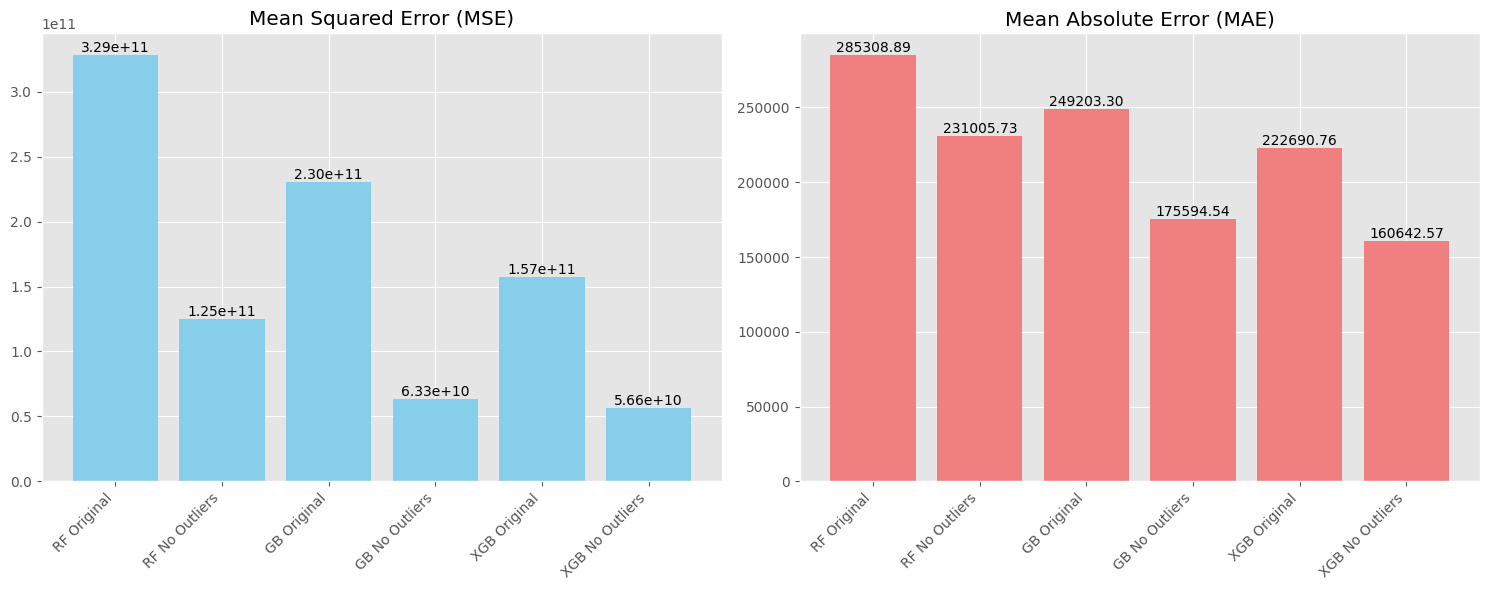

In [ ]:
# MSE and MAE results after hyperparameter optimization for each model
labels = ["RF Original", "RF No Outliers", "GB Original", "GB No Outliers", "XGB Original", "XGB No Outliers"]

# Values obtained after optimization
mse_values = [mse_rf, mse_rf_no, mse_gb, mse_gb_no, mse_xgb, mse_xgb_no]
mae_values = [mae_rf, mae_rf_no, mae_gb, mae_gb_no, mae_xgb, mae_xgb_no]

# Create positions for the bars
x = np.arange(len(labels))
width = 0.35  # Width of the bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# MSE Plot
bars_mse = ax1.bar(x, mse_values, color='skyblue')
ax1.set_title('Mean Squared Error (MSE)')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
for bar in bars_mse:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:.2e}', ha='center', va='bottom')

# MAE Plot
bars_mae = ax2.bar(x, mae_values, color='lightcoral')
ax2.set_title('Mean Absolute Error (MAE)')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
for bar in bars_mae:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2., height,
             f'{height:.2f}', ha='center', va='bottom')

# Adjust layout and display plot
plt.tight_layout()
plt.show()


# Model Evaluation:
- Compare the performance of all models (Decision Tree, Random Forest, Gradient Boosting, XGBoost).
- Visualize the feature importance for each model to understand which features contribute the most to the prediction.
- Report and compare the MAE, and MSE for each model.

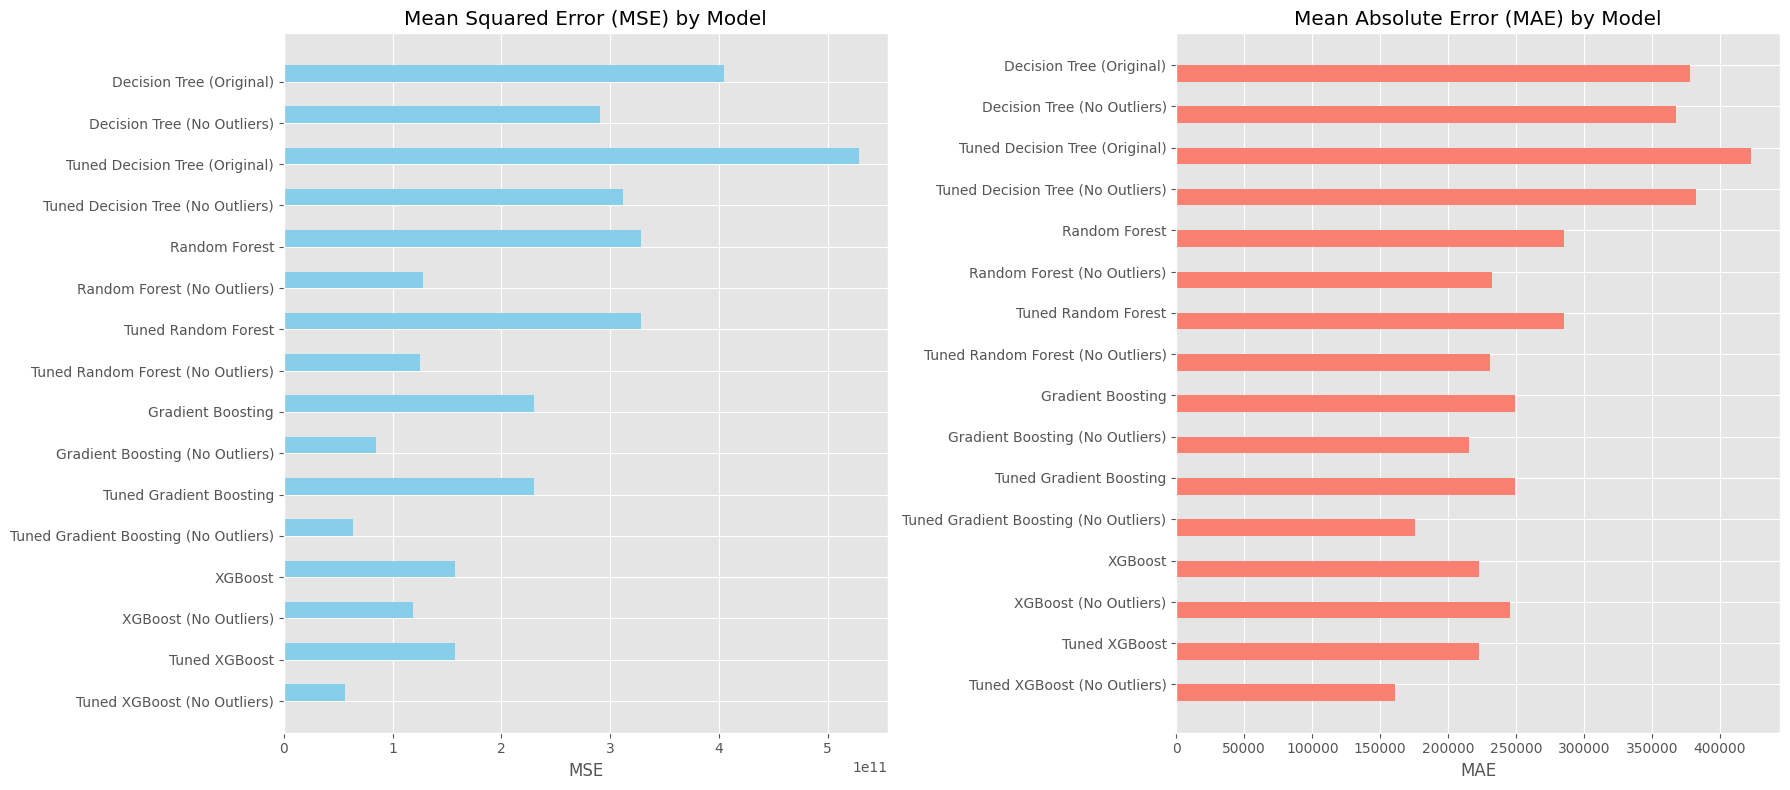

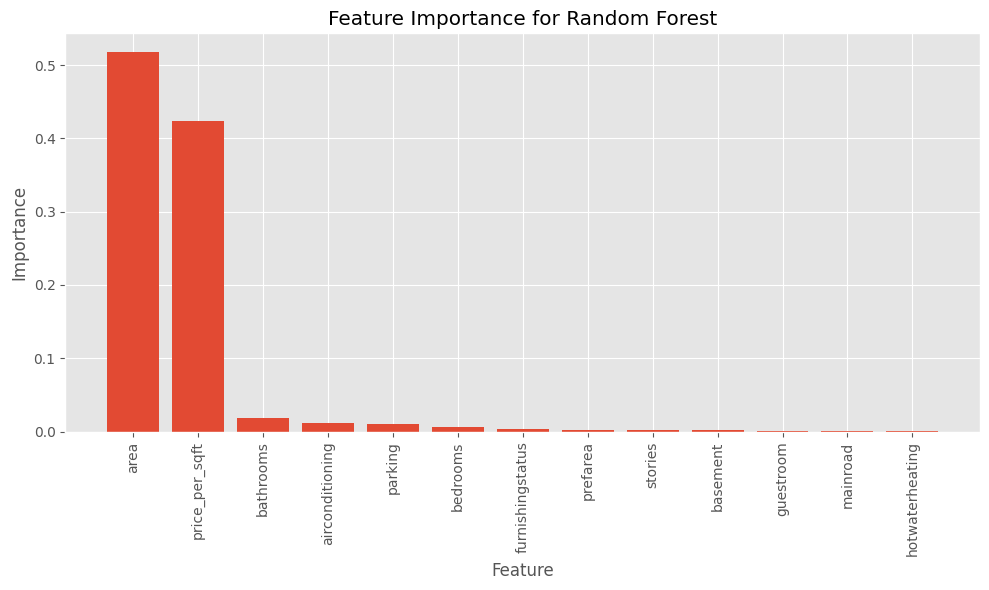

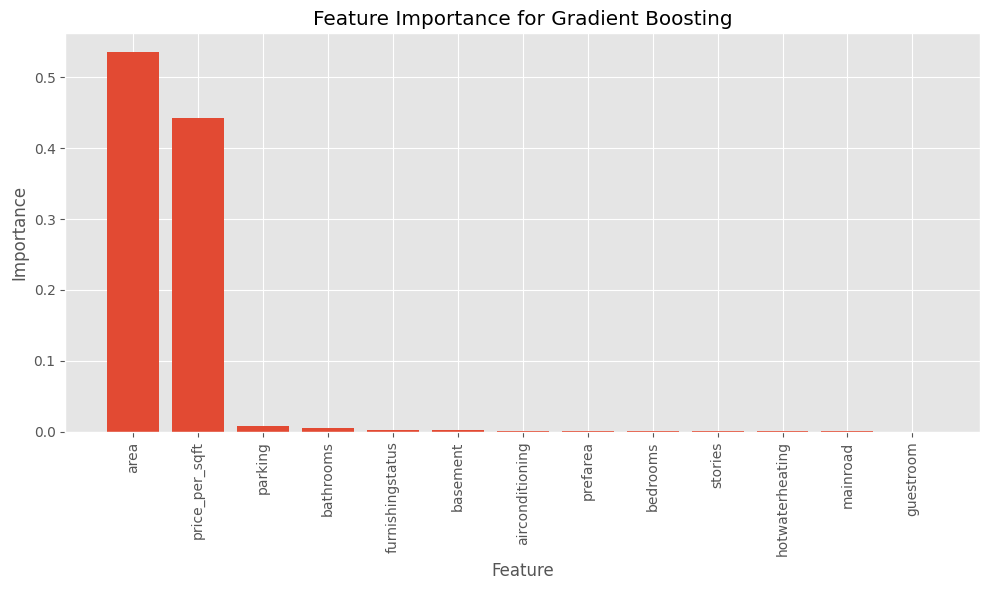

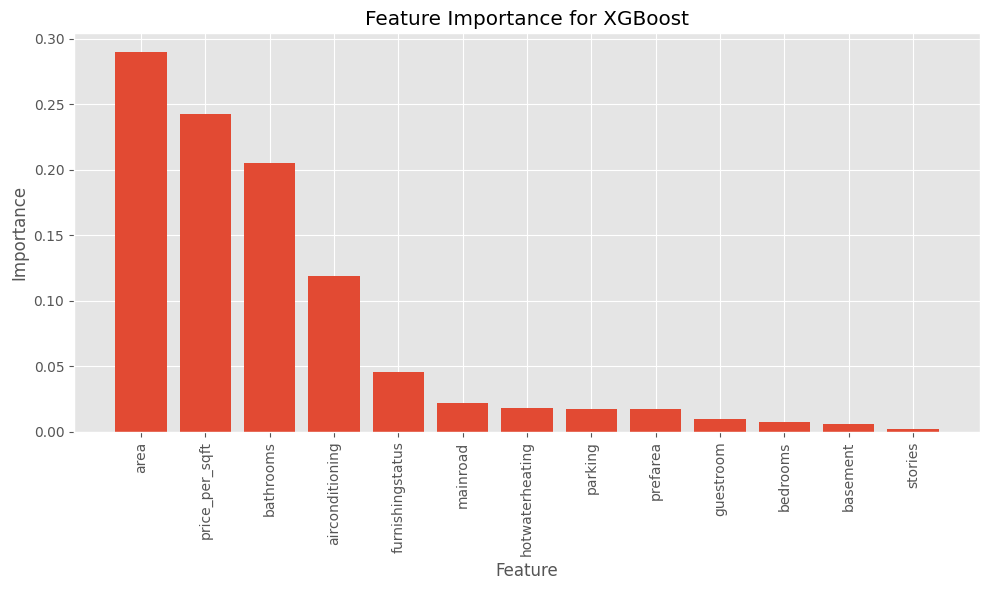

In [ ]:
# MSE and MAE results for each model and configuration
model_labels = [
    "Decision Tree (Original)", "Decision Tree (No Outliers)",
    "Tuned Decision Tree (Original)", "Tuned Decision Tree (No Outliers)",
    "Random Forest", "Random Forest (No Outliers)",
    "Tuned Random Forest", "Tuned Random Forest (No Outliers)",
    "Gradient Boosting", "Gradient Boosting (No Outliers)",
    "Tuned Gradient Boosting", "Tuned Gradient Boosting (No Outliers)",
    "XGBoost", "XGBoost (No Outliers)",
    "Tuned XGBoost", "Tuned XGBoost (No Outliers)"
]

mse_values = [
    mse_original, mse_no_outliers, mse_tuned_original, mse_tuned_no_outliers,
    mse_rf, mse_rf_noOutliers, best_mse_rf, best_mse_rf_no,
    mse_gb, mse_gb_noOutliers, best_mse_gb, best_mse_gb_no,
    mse_xgb, mse_xgb_noOutliers, best_mse_xgb, best_mse_xgb_no
]

mae_values = [
    mae_original, mae_no_outliers, mae_tuned_original, mae_tuned_no_outliers,
    mae_rf, mae_rf_noOutliers, best_mae_rf, best_mae_rf_no,
    mae_gb, mae_gb_noOutliers, best_mae_gb, best_mae_gb_no,
    mae_xgb, mae_xgb_noOutliers, best_mae_xgb, best_mae_xgb_no
]

x = np.arange(len(model_labels))
width = 0.4  # Width of bars

# Create subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# MSE Plot
ax1.barh(x - width/2, mse_values, color='skyblue', height=0.4)
ax1.set_yticks(x)
ax1.set_yticklabels(model_labels)
ax1.invert_yaxis()
ax1.set_title("Mean Squared Error (MSE) by Model")
ax1.set_xlabel("MSE")

# MAE Plot
ax2.barh(x + width/2, mae_values, color='salmon', height=0.4)
ax2.set_yticks(x)
ax2.set_yticklabels(model_labels)
ax2.invert_yaxis()
ax2.set_title("Mean Absolute Error (MAE) by Model")
ax2.set_xlabel("MAE")

plt.tight_layout()
plt.show()

#Feature importance visualization
# For each model that supports feature_importances_
feature_importance_data = {
    "Random Forest": best_rf.feature_importances_,
    "Gradient Boosting": best_gb.feature_importances_,
    "XGBoost": best_xgb.feature_importances_
}

# Display feature importance plots
for model_name, importances in feature_importance_data.items():
    plt.figure(figsize=(10, 6))
    sorted_idx = np.argsort(importances)[::-1]
    plt.bar(range(len(importances)), importances[sorted_idx], align='center')
    plt.xticks(range(len(importances)), np.array(X_train.columns)[sorted_idx], rotation=90)
    plt.title(f"Feature Importance for {model_name}")
    plt.xlabel("Feature")
    plt.ylabel("Importance")
    plt.tight_layout()
    plt.show()

In [ ]:
print("Model Evaluation Results:")
for label, mse, mae in zip(model_labels, mse_values, mae_values):
    print(f"{label} - MSE: {mse}, MAE: {mae}")

Model Evaluation Results:
Decision Tree (Original) - MSE: 404732470183.48627, MAE: 377775.2293577982
Decision Tree (No Outliers) - MSE: 290376289000.0, MAE: 367600.0
Tuned Decision Tree (Original) - MSE: 528580307479.9313, MAE: 422963.22629969416
Tuned Decision Tree (No Outliers) - MSE: 311398487604.8148, MAE: 382280.4444444445
Random Forest - MSE: 328544416728.4362, MAE: 285308.8884552087
Random Forest (No Outliers) - MSE: 127649686640.392, MAE: 232461.6933333333
Tuned Random Forest - MSE: 328544416728.4362, MAE: 285308.8884552087
Tuned Random Forest (No Outliers) - MSE: 125176591737.54936, MAE: 231005.7288888889
Gradient Boosting - MSE: 230208414782.2996, MAE: 249203.30100909874
Gradient Boosting (No Outliers) - MSE: 84739158100.70702, MAE: 215114.15786055085
Tuned Gradient Boosting - MSE: 230208414782.2996, MAE: 249203.30100909874
Tuned Gradient Boosting (No Outliers) - MSE: 63283635943.014175, MAE: 175594.54161379492
XGBoost - MSE: 157195686660.37915, MAE: 222690.75802752294
XGBoos